In [ ]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

In [610]:
def sigmoid(x):
    return 1 / (1 + (math.exp(-x)))

def n_sigmoid(x):
    return 1 / (1 + (np.exp(-x)))

def softmax(i, outputs):
    denominator = sum(math.exp(o) for o in outputs)
        
    if denominator == 0:
        return 0
    
    return math.exp(outputs[i]) / denominator

def n_softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting the max value for numerical stability
    return e_x / e_x.sum()

def cross_entropy(predictions, targets):
    loss = 0
    m = len(predictions)
    
    for j in range(m):
        loss += targets[j] * math.log(predictions[j])
    
    return -1 * loss

def binary_cross_entropy(prediction, target):
    return -1 * (target * math.log(prediction) + (1 - target) * math.log(1 - prediction))

def n_binary_cross_entropy(prediction, target):
    return -np.sum(target * np.log(prediction) + (1 - target) * np.log(1 - prediction))

def d_binary_cross_entropy(prediction, target):
    return -(target / prediction) + ((1 - target) / (1 - prediction))

def n_d_binary_cross_entropy(prediction, target):
    return -(target / prediction) + ((1 - target) / (1 - prediction))

def n_cross_entropy(predictions, targets):
    return -np.sum(targets * np.log(predictions))

def d_cross_entropy(predictions, targets):
    return [predictions[i] - targets[i] for i in range(len(targets))]

def n_d_cross_entropy(prediction, target):
    return prediction - target

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)
    
def n_d_sigmoid(x):
    s = n_sigmoid(x)
    return s * (1 - s)

def d_softmax_eq(i, outputs):
    s = softmax(i, outputs)
    return s * (1 - s)

def d_softmax_neq(i, j, outputs):
    s_i = softmax(i, outputs)
    s_j = softmax(j, outputs)
    return -s_i * s_j
            
def n_d_softmax_eq(i, outputs):
    s = n_softmax(i, outputs)
    return s[i] * (1 - s[i])

def n_d_softmax_neq(i, j, outputs):
    s = n_softmax(i, outputs)
    return -s[i] * s[j]            

def softmax_derivative(x):
    softmax_output = softmax(x)
    n = len(x)
    jacobian_matrix = []

    for i in range(n):
        row = []
        for j in range(n):
            if i == j:
                row.append(softmax_output[i] * (1 - softmax_output[i]))
            else:
                row.append(-softmax_output[i] * softmax_output[j])
        jacobian_matrix.append(row)

    return jacobian_matrix
    

In [ ]:
# size : 3
# sigmoid : activation
# in : in_act (x), weight (W), bias (b)
# out : out_act = activ(in_act * weight + bias)

# size : 2
# softmax : activation
# in : in_act (h), weight (V), bias (c)
# out : out_act = activ(in_act * weight + bias)
layers = [
    {
        'size': 3,
        'activation': 'sigmoid',
        'bias': True,
        'weights': [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]],
        'bias_weights': [0.0, 0.0, 0.0],
    },
    {
        'size': 2,
        'activation': 'softmax',
        'bias': True,
        'weights': [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]],
        'bias_weights': [0.0, 0.0]
    },
]


In [ ]:
num_of_x = 2

# initialize weights
def initialize(layers):
    in_act_size = num_of_x
    for j in range(len(layers)):
        s = layers[j]['size']
        
        if 'weights' not in layers[j]:
            # populate weights
            w = []
            for _ in range(in_act_size): # for each input
                w.append([random.uniform(0, 1) for _ in range(s)])
            layers[j]['weights'] = w
        
        dw = []
        for _ in range(in_act_size): # for each input
            dw.append([0] * s)
            
        layers[j]['d_w'] = dw
        
        if 'bias_weights' not in layers[j]:
            # populate bias
            if layers[j]['bias']:
                layers[j]['bias_weights'] = [random.uniform(0, 1) for _ in range(s)]
                
        layers[j]['d_b'] = [0] * s
        layers[j]['d_k'] = [0] * s
        layers[j]['d_h'] = [0] * s
        layers[j]['d_x'] = [0] * in_act_size
                
            
        in_act_size = s
        
initialize(layers)

In [ ]:
def cleanze(layers):
    for j in range(len(layers)):
        layers[j]['d_k'] = [0] * len(layers[j]['d_k'])
        layers[j]['d_h'] = [0] * len(layers[j]['d_h'])
        layers[j]['d_x'] = [0] * len(layers[j]['d_x'])
        layers[j]['in_act'] = [0] * len(layers[j]['in_act'])
        layers[j]['pre_act'] = [0] * len(layers[j]['pre_act'])
        layers[j]['post_act'] = [0] * len(layers[j]['post_act'])

def cleanze_gradients(layers):
    for j in range(len(layers)):
        layers[j]['d_w'] = [[0.0 for _ in range(len(layers[j]['d_w'][0]))] for _ in range(len(layers[j]['d_w']))]
        layers[j]['d_b'] = [0] * len(layers[j]['d_b'])
            

In [ ]:
def forward(layers, in_act):
    post_act = []
    for j in range(len(layers)):
        post_act.clear()
        # for each layer
        layer = layers[j]
        layers[j]['in_act'] = in_act.copy()
        
        # post_act = activ(in_act * weight + bias)
        weights = layer['weights']
        num_of_neurons = layer['size']
        act = layer['activation']
        
        pre_act = []
        # for each neuron
        for n in range(num_of_neurons):
            # k
            out_pre = 0
            for i in range(len(in_act)):
                out_pre += in_act[i] * weights[i][n] 
            if 'bias_weights' in layer:
                out_pre += layer['bias_weights'][n]
            pre_act.append(out_pre)
            
            # h
            if act == 'sigmoid':
                out_aft_act = sigmoid(out_pre)
            post_act.append(out_aft_act)
        layers[j]['pre_act'] = pre_act.copy()
        
        # o
        if act == 'softmax':
            out_softmax = []
            for n in range(num_of_neurons):
                out_softmax.append(softmax(n, post_act))
            post_act = out_softmax.copy()
        layers[j]['post_act'] = post_act.copy()
        
        # print(f'Layer: {j} - Output: {post_act}',)
        
        in_act = post_act.copy()
        
        
    return post_act
        

forward()
layers


In [ ]:
targets = [1, 0]
predictions = layers[-1]['post_act']
loss = cross_entropy(predictions, targets)
print(loss)

In [ ]:
predictions[0] - targets[0]

In [ ]:

n_layers = layers.copy()
def n_forward():
    in_act = np.array([1, -1]) # x inputs
    
    for j in range(len(n_layers)):
        # for each layer
        layer = n_layers[j]
        n_layers[j]['in_act'] = in_act.copy()
        
        # post_act = activ(in_act * weight + bias)
        weights = np.array(layer['weights'])
        bias_weights = np.array(layer['bias_weights'])

        pre_act = np.dot(in_act, weights)
        
        if 'bias_weights' in layer:
            pre_act += bias_weights
            
        n_layers[j]['pre_act'] = pre_act.copy()
        
        act = layer['activation']
        if act == 'sigmoid':
            post_act = n_sigmoid(pre_act)
        elif act == 'softmax':
            post_act = n_softmax(pre_act)

        n_layers[j]['post_act'] = post_act.copy()
        
        print(f'Layer: {j} - Output: {post_act}',)
        
        in_act = post_act.copy()
        
    return post_act

n_forward()
n_layers

In [ ]:
targets = [1, 0]
predictions = n_layers[-1]['post_act']
loss = n_cross_entropy(predictions, targets)
print(loss)
d_loss = d_cross_entropy(predictions, targets)
print(d_loss)

In [ ]:
forward()
layers

In [ ]:
# size : 2
# softmax : activation
# in : out_act = activ(in_act * weight + bias)
# out : in_act (h), weight (V), bias (c)

# in : 


# size : 3
# sigmoid : activation
# in : in_act (x), weight (W), bias (b)
# out : out_act = activ(in_act * weight + bias)

# def backward():
#     in_ = loss
#     # dl/do
#     d_h = [0.0, 0.0, 0.0] # d_cross_entropy(predictions, targets) # d_loss
    
#     for j in range(1): #len(layers)-1, 0, -1
        
#         layer = layers[j]
#         num_of_neurons = layer['size']
#         act = layer['activation']
#         post_act = layer['post_act']
#         in_act = layer['in_act']
#         weights = layer['weights']
        
#         for n in range(num_of_neurons): 
#             # deriv post activ
#             if act == 'sigmoid':
#                 print(n, d_h, post_act)
#                 layer['d_k'][n] = d_h[n] * post_act[n] * (1 - post_act[n])
#             print(layer['d_k'])
#             # deriv of weight
#             for i in range(len(in_act)):
#                 layer['d_w'][i][n] = layer['d_k'][n] * in_act[i]
                
#             # deriv of bias
#             layer['d_b'] = layer['d_k'].copy()
            
#             # deriv of in
#             for i in range(len(in_act)):
#                 layer['d_x'][i] += layer['d_k'][n] * weights[i][n]
                
#             d_h = layer['d_x'].copy()
            
        
# backward()
# layers  

In [ ]:
def train():
    pass

In [ ]:
import math

def softmax(x):
    e_x = [math.exp(i) for i in x]
    sum_e_x = sum(e_x)
    softmax_output = [i / sum_e_x for i in e_x]
    return softmax_output



# Example usage:
x = [0.5, 1.5]
softmax_derivative_result = softmax_derivative(x)
softmax_derivative_result


In [ ]:
initialize(layers)
post_act = forward(layers, [1, -1])
print(post_act)
layers

In [ ]:
post_act = forward(layers, [1, -1])
print(post_act)
layers

In [615]:
# Define the sigmoid and softmax gradient functions
def sigmoid_gradient(x):
    return x * (1 - x)

def softmax_gradient(x):
    sm = [0] * len(x)
    max_x = max(x)
    exp_x = [math.exp(xi - max_x) for xi in x]
    sum_exp_x = sum(exp_x)
    for i in range(len(x)):
        sm[i] = exp_x[i] / sum_exp_x * (1 - exp_x[i] / sum_exp_x)
    return sm

def backward(layers, y_outputs, t_targets):
    
    d_h = layers[-1]['d_h']
    for j in reversed(range(len(layers))):        
        layer = layers[j]
        act = layer['activation']
        num_of_neurons = layer['size']
        # pre_act = layer['pre_act']
        # d_w = layer['d_w'] # d_v
        # d_b = layer['d_b'] # d_c
        # d_x = layer['d_x'] # d_h
        weights = layer['weights']
        
        in_act = layer['in_act']
        
        if act == 'softmax':
            d_k = [(y_outputs[n] - t_targets[n]) for n in range(num_of_neurons)] # d_o
            layers[j]['d_k'] = d_k
            
            for n in range(num_of_neurons):
                for i in range(len(in_act)):
                    layers[j]['d_w'][i][n] += d_k[n] * in_act[i]
                    layers[j]['d_x'][i] += d_k[n] *  weights[i][n]
                
            layers[j]['d_b'] = [layers[j]['d_b'][b] + d_k[b] for b in range(len(layers[j]['d_b']))]
            
        elif act == 'sigmoid':
            post_act = layer['post_act']
            d_k = [(d_h[n] * (post_act[n] * (1 - post_act[n]))) for n in range(num_of_neurons)]

            for n in range(num_of_neurons):
                for i in range(len(in_act)):
                    layers[j]['d_w'][i][n] += d_k[n] * in_act[i]
                    layers[j]['d_x'][i] += d_k[n] *  weights[i][n]
                    
            layers[j]['d_b'] = [layers[j]['d_b'][b] + d_k[b] for b in range(len(layers[j]['d_b']))]
        
        
        d_h = layers[j]['d_x'].copy()
        
    return layers

# Example usage:
# import math

# targets = [1, 0]
# predictions = n_layers[-1]['post_act']
# loss = cross_entropy(predictions, targets)
# print(loss,predictions,targets)
# d_loss = d_cross_entropy(predictions, targets)
# print(d_loss)

# loss_gradient = [-2.0, 2.0]  # Replace with the actual loss gradient

# layers = backward(layers, [0.5, 0.5], [1, 0])
# layers


In [ ]:
x = [1,1,1]
y = [2,2,2]
[x[i] + y[i] for i in range(len(x))]

In [ ]:
cleanze(layers)
cleanze_gradients(layers)
layers

In [590]:
from data import load_synth
(xtrain, ytrain), (xval, yval), num_cls = load_synth()

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = arr.max() - arr.min()    
    for i in arr:
        temp = (((i - arr.min())*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def target_arr(num_cls, t):
    arr = [0] * num_cls
    arr[t] = 1
    return arr


norm_train_x = normalize(xtrain, 0, 1)
# norm_val_x = normalize(xval, 0, 1)

norm_train_y = normalize(ytrain, 0, 1)
norm_val_y = normalize(yval, 0, 1)

init: [{'size': 3, 'activation': 'sigmoid', 'bias': True, 'weights': [[0.06021192625193528, 0.0721780847622594, 0.14633454994537676], [0.49330473284942467, 0.0036015947349626876, 0.5505878879959706]], 'd_w': [[0, 0, 0], [0, 0, 0]], 'bias_weights': [0.9732960952105992, 0.5344317842077743, 0.7882559555133724], 'd_b': [0, 0, 0], 'd_k': [0, 0, 0], 'd_h': [0, 0, 0], 'd_x': [0, 0]}, {'size': 2, 'activation': 'softmax', 'bias': True, 'weights': [[0.33694857350342455, 0.8137090244733777], [0.6873574371937923, 0.6297137739921426], [0.4680289445511583, 0.48569777186806895]], 'd_w': [[0, 0], [0, 0], [0, 0]], 'bias_weights': [0.8124845178436907, 0.8588768277446455], 'd_b': [0, 0], 'd_k': [0, 0], 'd_h': [0, 0], 'd_x': [0, 0, 0]}]
j: 0, OLD WEIGHTS: [[0.06021192625193528, 0.0721780847622594, 0.14633454994537676], [0.49330473284942467, 0.0036015947349626876, 0.5505878879959706]], OLD BIAS: [0.9732960952105992, 0.5344317842077743, 0.7882559555133724]
j: 0, NEW WEIGHTS: [[0.04177079889868961, 0.0750966

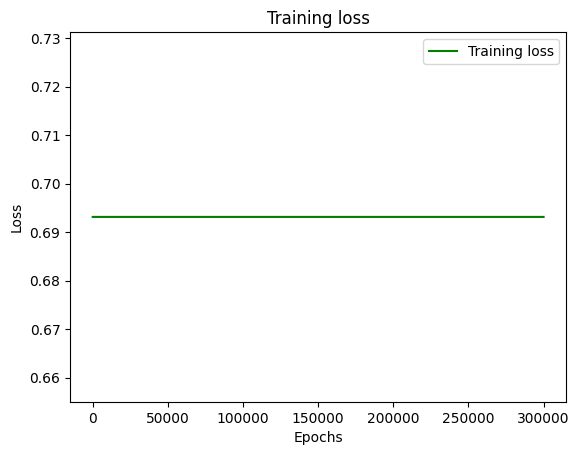

[{'size': 3,
  'activation': 'sigmoid',
  'bias': True,
  'weights': [[0.14471689525843384, 0.2722504920669728, 0.3147540736514066],
   [0.5420337537617886, 0.11897152663543624, 0.6477054727865673]],
  'd_w': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
  'bias_weights': [1.0882129737941328, 0.8065068681755614, 1.0172868182469286],
  'd_b': [0, 0, 0],
  'd_k': [0, 0, 0],
  'd_h': [0, 0, 0],
  'd_x': [0, 0],
  'in_act': [0, 0],
  'pre_act': [0, 0, 0],
  'post_act': [0, 0, 0]},
 {'size': 2,
  'activation': 'softmax',
  'bias': True,
  'weights': [[1.4960853896361008, -0.3454277916592986],
   [1.6863507531741253, -0.3692795419881907],
   [1.622898653782873, -0.6691719373636456]],
  'd_w': [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]],
  'bias_weights': [2.312484517843691, -0.6411231722553548],
  'd_b': [0, 0],
  'd_k': [0, 0],
  'd_h': [0, 0],
  'd_x': [0, 0, 0],
  'in_act': [0, 0, 0],
  'pre_act': [0, 0],
  'post_act': [0, 0]}]

In [619]:

layers = [
    {
        'size': 3,
        'activation': 'sigmoid',
        'bias': True,
        # 'weights': [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]],
        # 'bias_weights': [0.0, 0.0, 0.0],
    },
    {
        'size': 2,
        'activation': 'softmax',
        'bias': True,
        # 'weights': [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]],
        # 'bias_weights': [0.0, 0.0]
    },
]

# Define hyperparameters
learning_rate = 1e-5
epochs = 5

# test_data = [
#     [1, 0],
#     [1, 0],
#     [-1, 0],
#     [-1, 0],
#     [1, 0],
#     [-1, 0],
# ]

# targets = [
#     [1, 0],
#     [1, 0],
#     [0, 1],
#     [0, 1],
#     [1, 0],
#     [0, 1],
# ]

ep_len = len(norm_train_x)


initialize(layers)
losses = []

print(f'init: {layers}')
# Training loop
for epoch in range(epochs):
    
    for ep in range(ep_len):

        # real
        x1, x2 = norm_train_x[i]
        y = 0 if norm_train_y[i] == 1 else 1 
        t_targets = target_arr(num_cls, y)
        x_inputs = [x1, x2]
            
        # test
        # x_inputs = [1, -1]
        # t_targets = [1, 0]
            
        # Forward Pass
        post_act = forward(layers, x_inputs)
        
        # print(f'forward: {layers}')

        # Calculate the cross-entropy loss
        loss = cross_entropy(post_act, t_targets)

        # Backward pass
        backward(layers, post_act, t_targets)
        
        # print(f'backward: {layers}')

        # Clear in (x), pre(k), post(h)
        cleanze(layers)
        
        # if ep % 10 == 0:
        #     print(f'Epoch {epoch + 1}/{epochs}, EP {ep+1}/{ep_len} Loss: {loss}, PA: {post_act}')
        losses.append(loss)
            
    # Update weights and biases
    for j in range(len(layers)):
        print(f'j: {j}, OLD WEIGHTS: {layers[j]['weights']}, OLD BIAS: {layers[j]['bias_weights']}')
        for n in range(layers[j]['size']):
            for i in range(len(layers[j]['in_act'])):
                layers[j]['weights'][i][n] += -learning_rate * layers[j]['d_w'][i][n]
            if 'bias_weights' in layers[j]:
                layers[j]['bias_weights'][n] += -learning_rate * layers[j]['d_b'][n]
        print(f'j: {j}, NEW WEIGHTS: {layers[j]['weights']}, NEW BIAS: {layers[j]['bias_weights']}')
                
    cleanze_gradients(layers)
    
loss_train = losses
episodes = range(0,len(losses))
plt.plot(episodes, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
      
layers

In [ ]:
post_act = forward(layers, [50, 1, 1]) # [0, 1]
post_act

In [ ]:
def cross_entropy_loss(target, output):
    return -sum([target[i] * math.log(output[i]) for i in range(len(target))])

In [ ]:
cross_entropy_loss(targets, predictions)

In [616]:
# ONE PASS
layers = [
    {
        'size': 3,
        'activation': 'sigmoid',
        'bias': True,
        'weights': [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]],
        'bias_weights': [0.0, 0.0, 0.0],
    },
    {
        'size': 2,
        'activation': 'softmax',
        'bias': True,
        'weights': [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]],
        'bias_weights': [0.0, 0.0]
    },
]

epochs = 1
ep_len = 1 

initialize(layers)

# Training loop
for epoch in range(1):
    
    for ep in range(1):
            
        # test
        x_inputs = [1, -1]
        t_targets = [1, 0]
            
        # Forward Pass
        post_act = forward(layers, x_inputs)

        # Calculate the cross-entropy loss
        loss = cross_entropy(post_act, t_targets)

        # Backward pass
        backward(layers, post_act, t_targets)

layers

[{'size': 3,
  'activation': 'sigmoid',
  'bias': True,
  'weights': [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]],
  'bias_weights': [0.0, 0.0, 0.0],
  'd_w': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
  'd_b': [0.0, 0.0, 0.0],
  'd_k': [0, 0, 0],
  'd_h': [0, 0, 0],
  'd_x': [0.0, 0.0],
  'in_act': [1, -1],
  'pre_act': [2.0, 2.0, 2.0],
  'post_act': [0.8807970779778823, 0.8807970779778823, 0.8807970779778823]},
 {'size': 2,
  'activation': 'softmax',
  'bias': True,
  'weights': [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]],
  'bias_weights': [0.0, 0.0],
  'd_w': [[-0.44039853898894116, 0.44039853898894116],
   [-0.44039853898894116, 0.44039853898894116],
   [-0.44039853898894116, 0.44039853898894116]],
  'd_b': [-0.5, 0.5],
  'd_k': [-0.5, 0.5],
  'd_h': [0, 0],
  'd_x': [0.0, 0.0, 0.0],
  'in_act': [0.8807970779778823, 0.8807970779778823, 0.8807970779778823],
  'pre_act': [-0.8807970779778823, -0.8807970779778823],
  'post_act': [0.5, 0.5]}]

In [609]:
n_d_sigmoid([0, 0, 0])

TypeError: bad operand type for unary -: 'list'